In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage.transform import resize

In [4]:
import numpy as np
images = np.load("/content/drive/MyDrive/brain_tumor_dataset/images.npy", allow_pickle=True)
masks = np.load("/content/drive/MyDrive/brain_tumor_dataset/masks.npy", allow_pickle=True)
labels = np.load("/content/drive/MyDrive/brain_tumor_dataset/labels.npy")
integer_to_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary tumor'}

print(f"images:{images.shape}, \
masks:{masks.shape}, \
labels:{labels.shape}")

images:(3064,), masks:(3064,), labels:(3064,)


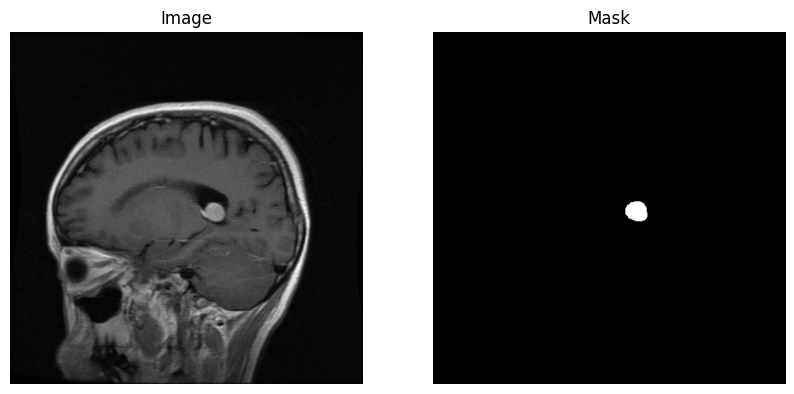

In [7]:
import matplotlib.pyplot as plt
def display_sample(data, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(data['images'][index], cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(data['masks'][index], cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.show()

# Display a sample to verify
display_sample({'images': images, 'masks': masks}, index=0)

In [8]:
from skimage.transform import resize
def preprocess_images(images, masks, target_shape=(256, 256)):
    processed_images = np.array([resize(img, target_shape, preserve_range=True) for img in images])
    processed_masks = np.array([resize(mask, target_shape, mode='constant', anti_aliasing=False) for mask in masks])

    # Normalize images
    processed_images = processed_images.astype('float32') / 255.0

    return processed_images, processed_masks

images_processed, masks_processed = preprocess_images(images, masks)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images_processed, masks_processed, test_size=0.2, random_state=42)

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, concatenate, Add

def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same'):
    x = Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def down_block(inputs, filters, pool_size=(2, 2)):
    x = conv_block(inputs, filters)
    pool = MaxPooling2D(pool_size)(x)
    return x, pool

def up_block(inputs, skip, filters, up_size=(2, 2)):
    x = UpSampling2D(up_size)(inputs)
    # Ensure the spatial dimensions of the upsampled feature map match the skip connection
    x = concatenate([x[:, :skip.shape[1], :skip.shape[2], :], skip], axis=3)
    x = conv_block(x, filters)
    return x


def laddernet_model(input_size=(256, 256, 1), filters=16, num_classes=1):
    inputs = Input(input_size)

    # Encoder
    e1, p1 = down_block(inputs, filters)
    e2, p2 = down_block(p1, filters * 2)
    e3, p3 = down_block(p2, filters * 4)
    e4, _ = down_block(p3, filters * 8)

    # Bottleneck
    b = conv_block(e4, filters * 16)

    # Decoder
    d4 = up_block(b, e4, filters * 8)
    d3 = up_block(d4, e3, filters * 4)
    d2 = up_block(d3, e2, filters * 2)
    d1 = up_block(d2, e1, filters)

    # Skip connections
    skip_d4 = Add()([d4, e4])
    skip_d3 = Add()([d3, e3])
    skip_d2 = Add()([d2, e2])
    skip_d1 = Add()([d1, e1])

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(skip_d1)
    model = Model(inputs, outputs)
    return model

model = laddernet_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 256, 256, 16)         160       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_10 (Ba  (None, 256, 256, 16)         64        ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_10 (Activation)  (None, 256, 256, 16)         0         ['batch_normalization_10[0

In [12]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=20)



Epoch 1/20
307/307 [==============================] - 66s 137ms/step - loss: 0.1553 - accuracy: 0.9687 - val_loss: 0.0957 - val_accuracy: 0.9831
Epoch 2/20
307/307 [==============================] - 33s 108ms/step - loss: 0.0681 - accuracy: 0.9831 - val_loss: 0.0934 - val_accuracy: 0.9654
Epoch 3/20
307/307 [==============================] - 33s 109ms/step - loss: 0.0520 - accuracy: 0.9847 - val_loss: 0.0781 - val_accuracy: 0.9728
Epoch 4/20
307/307 [==============================] - 34s 110ms/step - loss: 0.0428 - accuracy: 0.9864 - val_loss: 0.0488 - val_accuracy: 0.9861
Epoch 5/20
307/307 [==============================] - 34s 110ms/step - loss: 0.0374 - accuracy: 0.9876 - val_loss: 0.0439 - val_accuracy: 0.9862
Epoch 6/20
307/307 [==============================] - 33s 108ms/step - loss: 0.0320 - accuracy: 0.9889 - val_loss: 0.0361 - val_accuracy: 0.9881
Epoch 7/20
307/307 [==============================] - 34s 110ms/step - loss: 0.0278 - accuracy: 0.9902 - val_loss: 0.0377 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


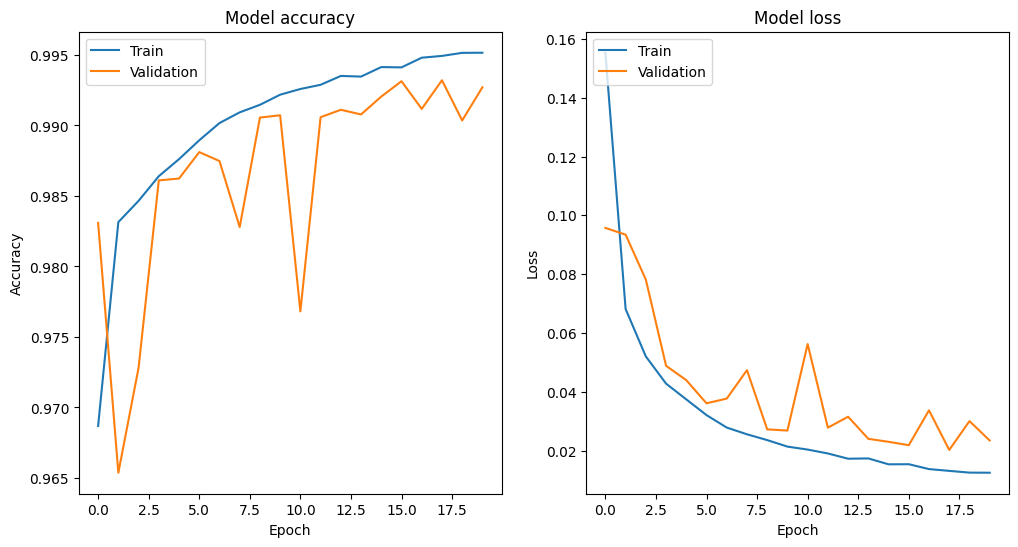

In [13]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
if 'dice_coefficient' in history.history:
    plt.figure(figsize=(6, 5))
    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    plt.title('Model Dice Coefficient')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [14]:
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation accuracy:", accuracy)
predictions = model.predict(X_val)

20/20 [==============================] - 7s 107ms/step - loss: 0.0234 - accuracy: 0.9927
Validation accuracy: 0.9927088618278503
20/20 [==============================] - 2s 107ms/step


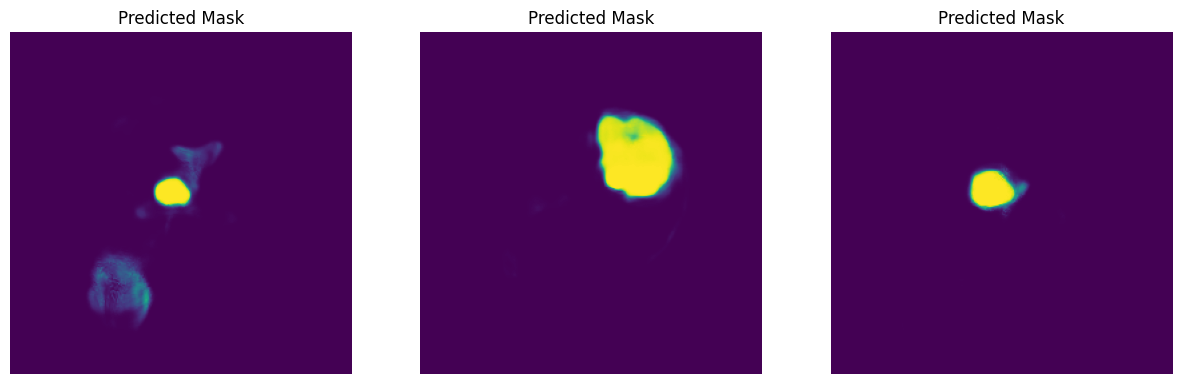

In [15]:
def display_comparison(indices):
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i+1)
        plt.imshow(np.squeeze(predictions[idx]), cmap='viridis')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()
display_comparison([0, 1, 2])

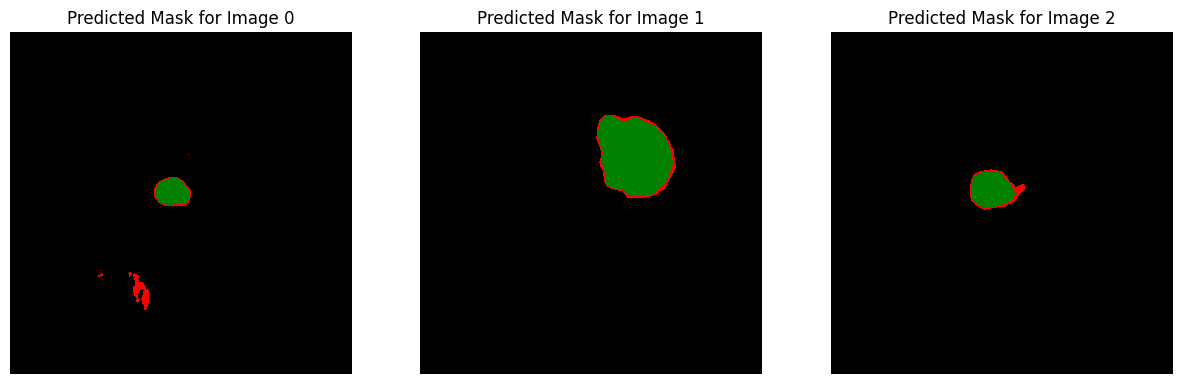

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
colors = ['black', 'red', 'green']  # Add more colors if there are more classes
cmap = ListedColormap(colors)

def display_comparison(predictions, indices):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i+1)
        plt.imshow(np.squeeze(predictions[idx]), cmap=cmap)
        plt.title(f'Predicted Mask for Image {idx}')
        plt.axis('off')
    plt.show()
display_comparison(predictions, [0, 1, 2])


In [18]:
predicted_masks = model.predict(X_val)

20/20 [==============================] - 2s 105ms/step


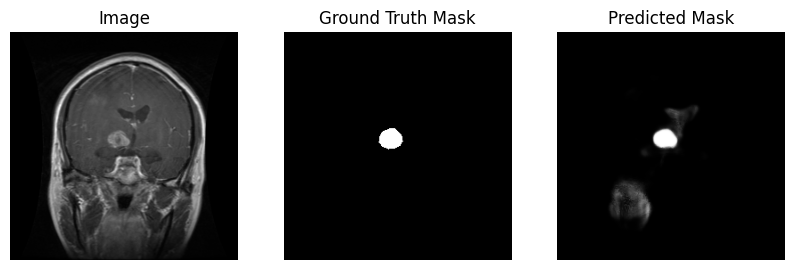

In [19]:
def display_predicted_masks(images, masks, predicted_masks, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images[index], cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[index], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[index].reshape(256, 256), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

# Display a sample of predicted masks on original images
display_predicted_masks(X_val, y_val, predicted_masks, index=0)

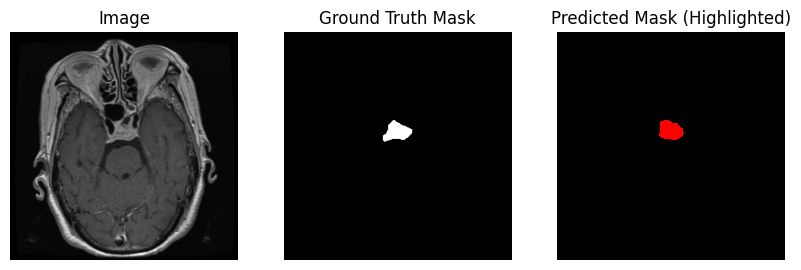

In [20]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['black', 'red'])

def display_predicted_masks(images, masks, predicted_masks, index):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(images[index], cmap='gray')
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[index], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks[index].reshape(256, 256), cmap=cmap)
    plt.title('Predicted Mask (Highlighted)')
    plt.axis('off')

    plt.show()
display_predicted_masks(X_val, y_val, predicted_masks, index=150)
